In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import sys
import os, os.path
import shutil
sys.path.append('/storage1/francesco/scripts/BME2/')
sys.path.append('../Results_and_analysis/')
from tools import *
import BME as bme
import scipy.stats as scs
from random import seed
from random import random
import string

def col0(frame):
    return(int(frame[5:]))

def kld(p,q):
    p[p==0] = 1e-50
    q[q==0] = 1e-50
    
    div = scs.entropy(p,q)
    return(div)

In [2]:
mpl.rcParams['font.size'] = 15
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

## Generate synthetic dataset from Hst5 ensemble

In [3]:
#TEST SET HST5 323K GP140
q = np.loadtxt('saxs323k_bme.txt')[...,0]
rg = np.loadtxt('RG.dat')
saxs = np.loadtxt('ensemble_saxs.txt',converters = {0: col0})[...,1:]

In [4]:
# Computing synthetic weights
seed(30)
w_mod = []
for i in range(5):
    mod = (20+random()*10)*np.exp(-(rg-(1.2+random()*0.4))**4)
    w_mod.append(np.array(np.exp((1-mod))))

In [5]:
# Synthetic Rg distributions
x = np.linspace( rg.min()-0.2, rg.max()+0.2, num = 100 )

rg_av_uniform = np.average(rg)
kde_uniform = scs.gaussian_kde( rg, bw_method = "silverman" ).evaluate(x)

kde_synthetic = []
rg_av_synthetic = []
for i in range(5):
    rg_av_synthetic.append(np.average(rg, weights=w_mod[i]))
    kde_synthetic.append(scs.gaussian_kde( rg, bw_method = "silverman", weights = w_mod[i] ).evaluate(x))

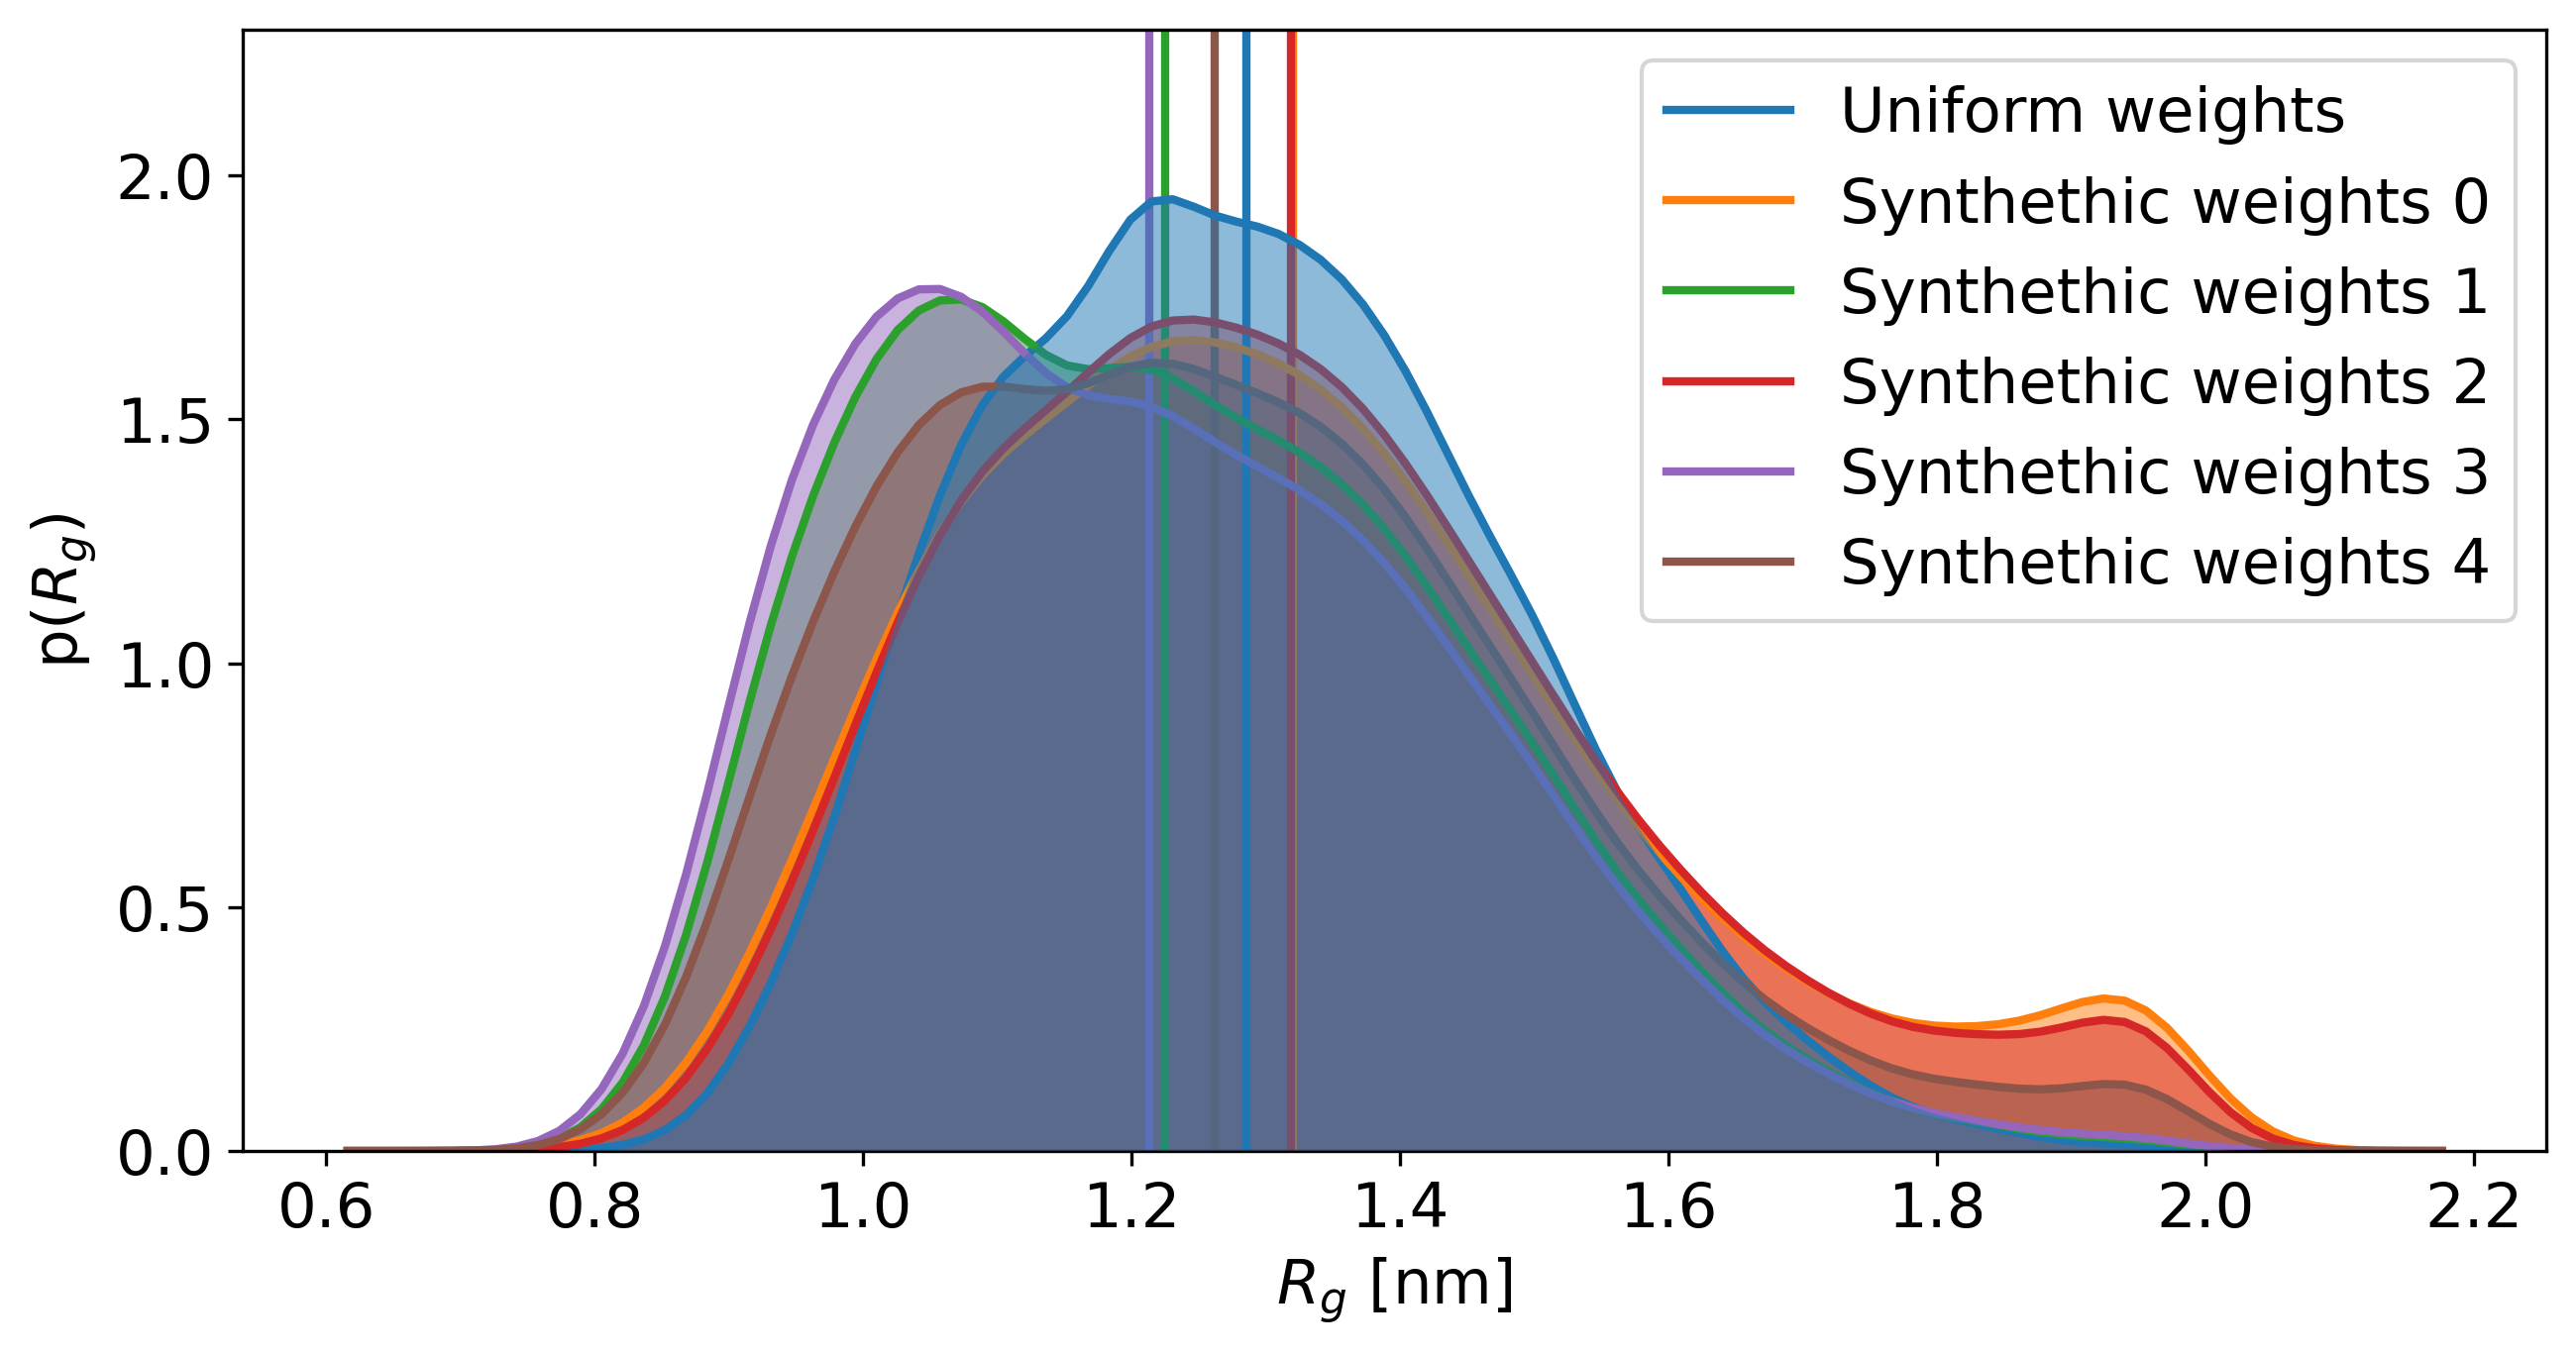

In [6]:
plt.figure(figsize=(10,5),dpi=300)

plt.plot(x,kde_uniform,label='Uniform weights',linewidth=2)
plt.fill_between(x,kde_uniform,0,alpha=0.5,zorder=100)
plt.vlines(rg_av_uniform,-0.5,2.5,color=colors[0],linewidth=2)

for i in range(5):
    plt.plot(x,kde_synthetic[i],label='Synthethic weights '+str(int(i)),linewidth=2)
    plt.fill_between(x,kde_synthetic[i],0,alpha=0.5)
    plt.vlines(rg_av_synthetic[i],-0.5,2.5,color=colors[i+1],linewidth=2)

plt.ylim(0,2.30)
plt.legend(loc='upper right')
plt.ylabel(r'p($R_g$)')
plt.xlabel(r'$R_g$ [nm]')
plt.savefig('rg_syn.png', dpi=300, facecolor='w', edgecolor='w', orientation='portrait')
plt.show()

## Uniform distribution is the target (exp data)
## Synthetic distributions are the priors

In [7]:
# Generate SAXS data for BME
saxs_ens = np.average(saxs, axis=0)
err = (saxs_ens*(0.5/100))*np.exp(q) #Synthetic errors mimicking the typical experimental SAXS errors
np.savetxt('exp_saxs_tmp.txt',np.vstack((q,saxs_ens,err)).T, fmt='%10.5f', delimiter=' ', newline='\n')
! echo "# DATA=SAXS PRIOR=GAUSS" > exp_saxs.txt
! cat exp_saxs_tmp.txt >> exp_saxs.txt
! rm exp_saxs_tmp.txt

/storage1/francesco/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/storage1/francesco/software/miniconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


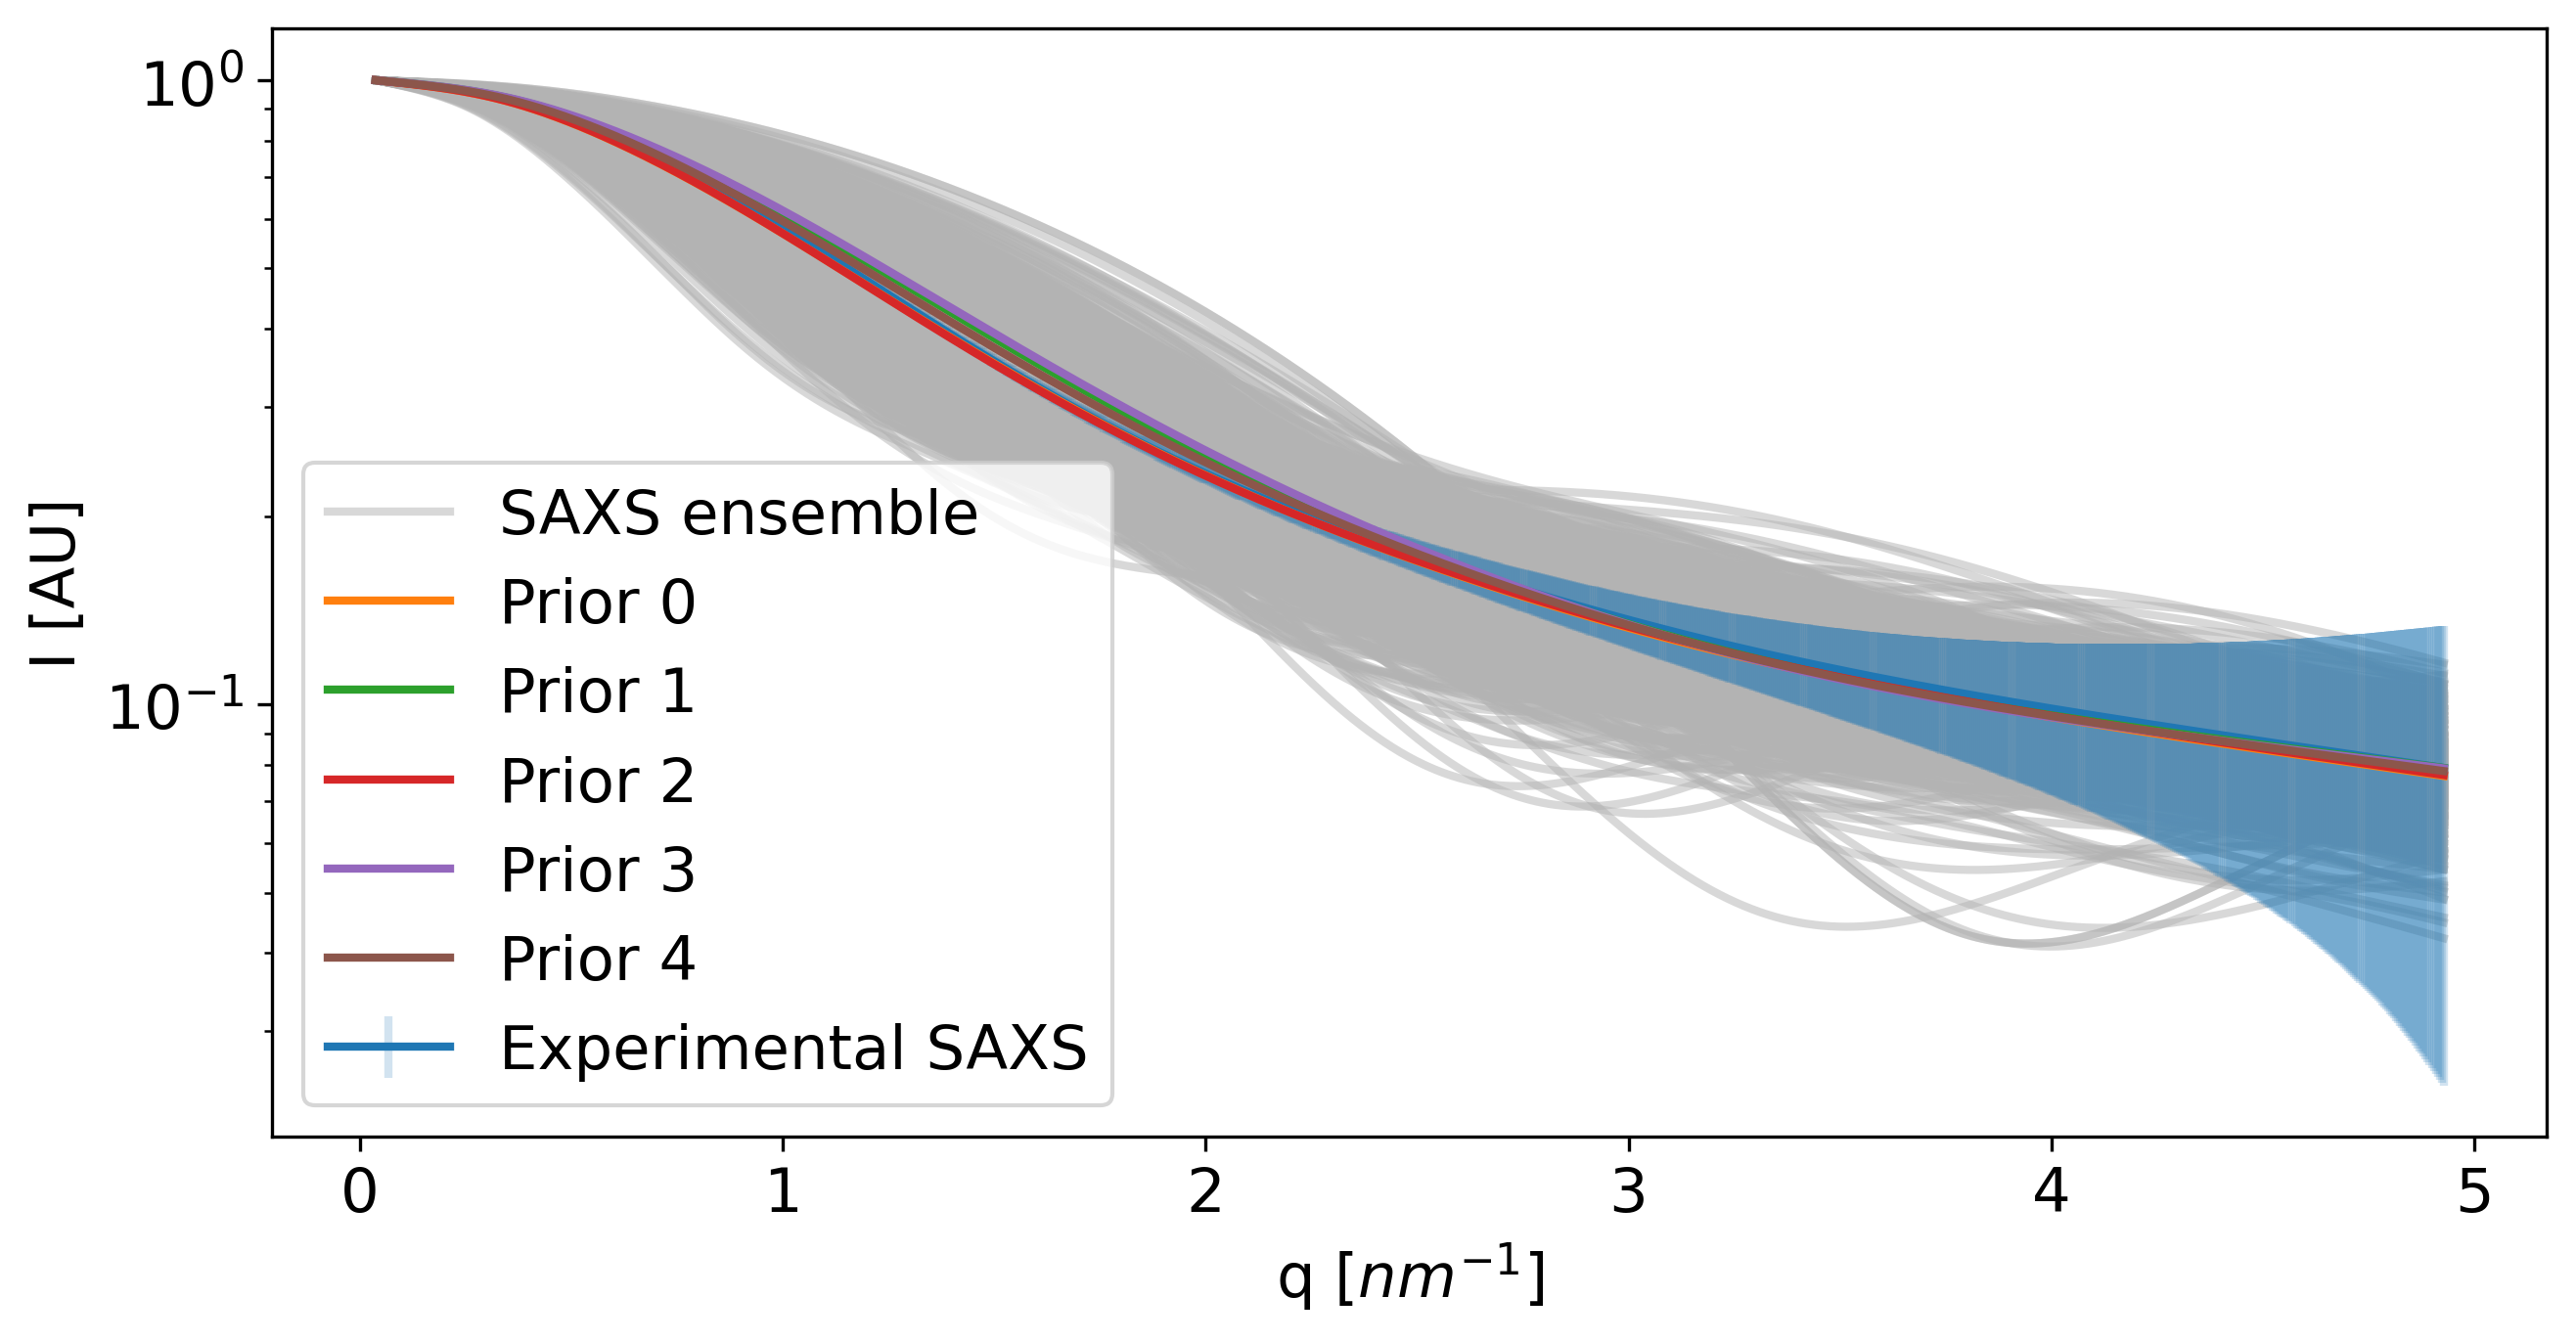

In [8]:
mpl.rcParams['font.size'] = 15
plt.fig = plt.figure(figsize=(10,5), dpi = 300, facecolor='w')

plt.plot(q,saxs[0],c='0.7',linewidth=2,alpha=0.5,label='SAXS ensemble')
for i in range(0,np.shape(saxs)[0],10):
    plt.plot(q,saxs[i],c='0.7',linewidth=2,alpha=0.5)
    
markers, caps, bars = plt.errorbar(q,saxs_ens,err,linewidth=2,label='Experimental SAXS',zorder=100)
[bar.set_alpha(0.2) for bar in bars]

for i in range(5):
    saxs_ens_mod = np.average(saxs, weights=w_mod[i], axis=0)
    plt.plot(q,saxs_ens_mod,linewidth=2,label='Prior '+str(int(i)),zorder=500)
    
plt.xlabel(r'q [$nm^{-1}$]')
plt.ylabel(r'I [AU]')
plt.legend()

plt.yscale('log')
#plt.xscale('log')
plt.savefig('saxs_syn.png', dpi=300, facecolor='w', edgecolor='w', orientation='portrait')


plt.show()

## Plain BME reweighting of the syntethic priors without fitting scale and constant background

In [9]:
t = 100
exp_file = 'exp_saxs.txt'
calc_file = 'ensemble_saxs.txt'

In [10]:
REdata_stand = []
REw_stand = []

for n in range(5):
    rew = bme.Reweight("prior_"+str(n),w0=w_mod[n])
    rew.load(exp_file,calc_file,fit="no")
    chi2_before, chi2_after, phi = rew.fit(theta=100)
    REdata_stand.append(np.array([t, chi2_before, chi2_after, phi]))
    REw_stand.append(rew.get_weights())

## Random changes of scale and constant background of the SAXS priors

In [11]:
seed(65416523)
scale_factors = np.array([random(), random(), random(), random(), random()])*5

seed(261645625)
offsets = np.array([random(), random(), random(), random(), random()])

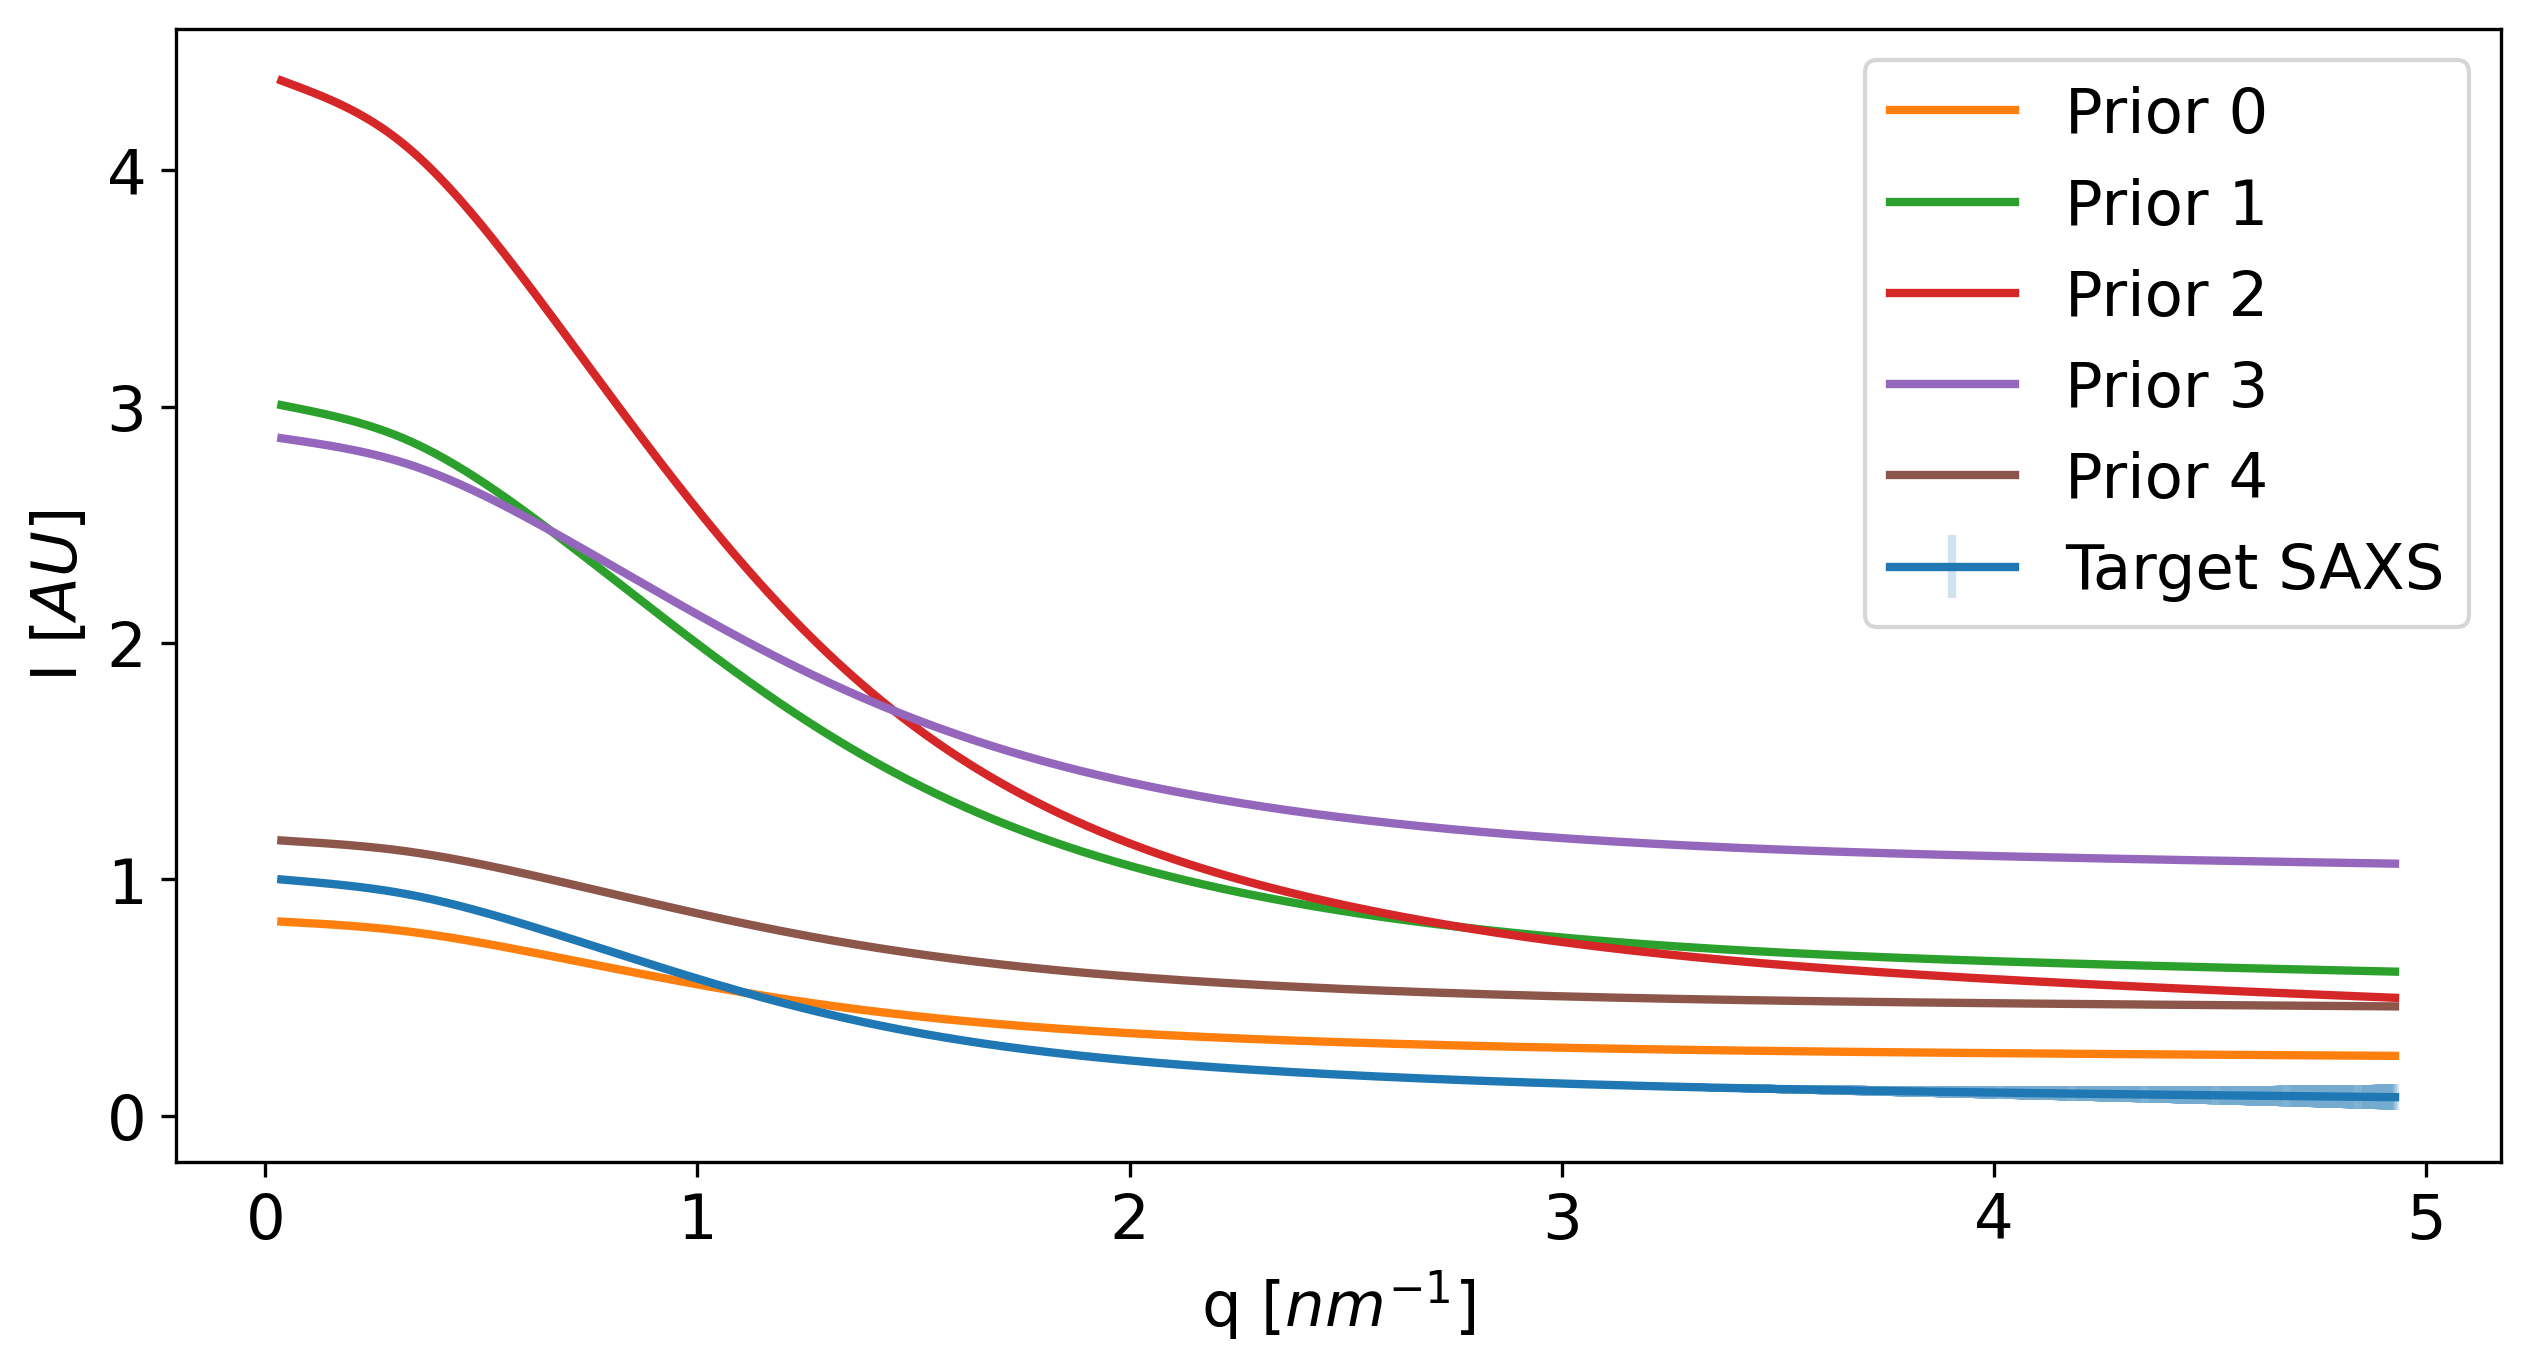

In [12]:
mpl.rcParams['font.size'] = 15

plt.fig = plt.figure(figsize=(10, 5), facecolor='white', dpi = 300)

markers, caps, bars = plt.errorbar(q,saxs_ens,err,linewidth=2,label='Target SAXS',zorder=100)
[bar.set_alpha(0.2) for bar in bars]

for i in range(5):
    saxs_ens_mod = np.average(saxs, weights=w_mod[i], axis=0)
    plt.plot(q,scale_factors[i]*saxs_ens_mod+offsets[i],linewidth=2,label='Prior '+str(int(i)))

plt.xlabel(r'q $[nm^{-1}]$')
plt.ylabel(r'I $[AU]$')
plt.legend()
plt.savefig('saxs_syn_mod.png', dpi=300, facecolor='w', edgecolor='w', orientation='portrait')

plt.show()

## BME reweighting of the priors from the new SAXS ensembles fitting scale and constant background using iBME

In [13]:
ndx = np.arange(np.shape(saxs)[0]).reshape(10000,1)

ibme_stats = {}
ibme_weights = {}
for n in range(5):
    saxs_perturbation = scale_factors[n]*saxs+offsets[n]
    saxs_perturbation = np.hstack((ndx,saxs_perturbation))
    np.savetxt('calc_saxs_N'+str(int(n))+'.txt',saxs_perturbation, fmt='%10.5e', delimiter=' ', newline='\n')

    t = 100
    rew = bme.Reweight("prior_"+str(n),w0=w_mod[n])
    rew.load(exp_file,calc_file)
    rew.ibme(theta=t, iterations=20, ftol=2.1587e-100)
    ibme_stats[n] = rew.get_ibme_stats()
    ibme_weights[n] = rew.get_ibme_weights()

In [14]:
# Relative entropy of the weights from iBME and the ones from the plain BME (without changing scale/constant background)
ibme_srel = {}
for n in range(5):
    tmp = []
    for i in range(20):
        tmp.append(kld(REw_stand[n],ibme_weights[n][i]))
    ibme_srel[n] = np.array(tmp)

## Comparison of the observables from plain BME and iBME

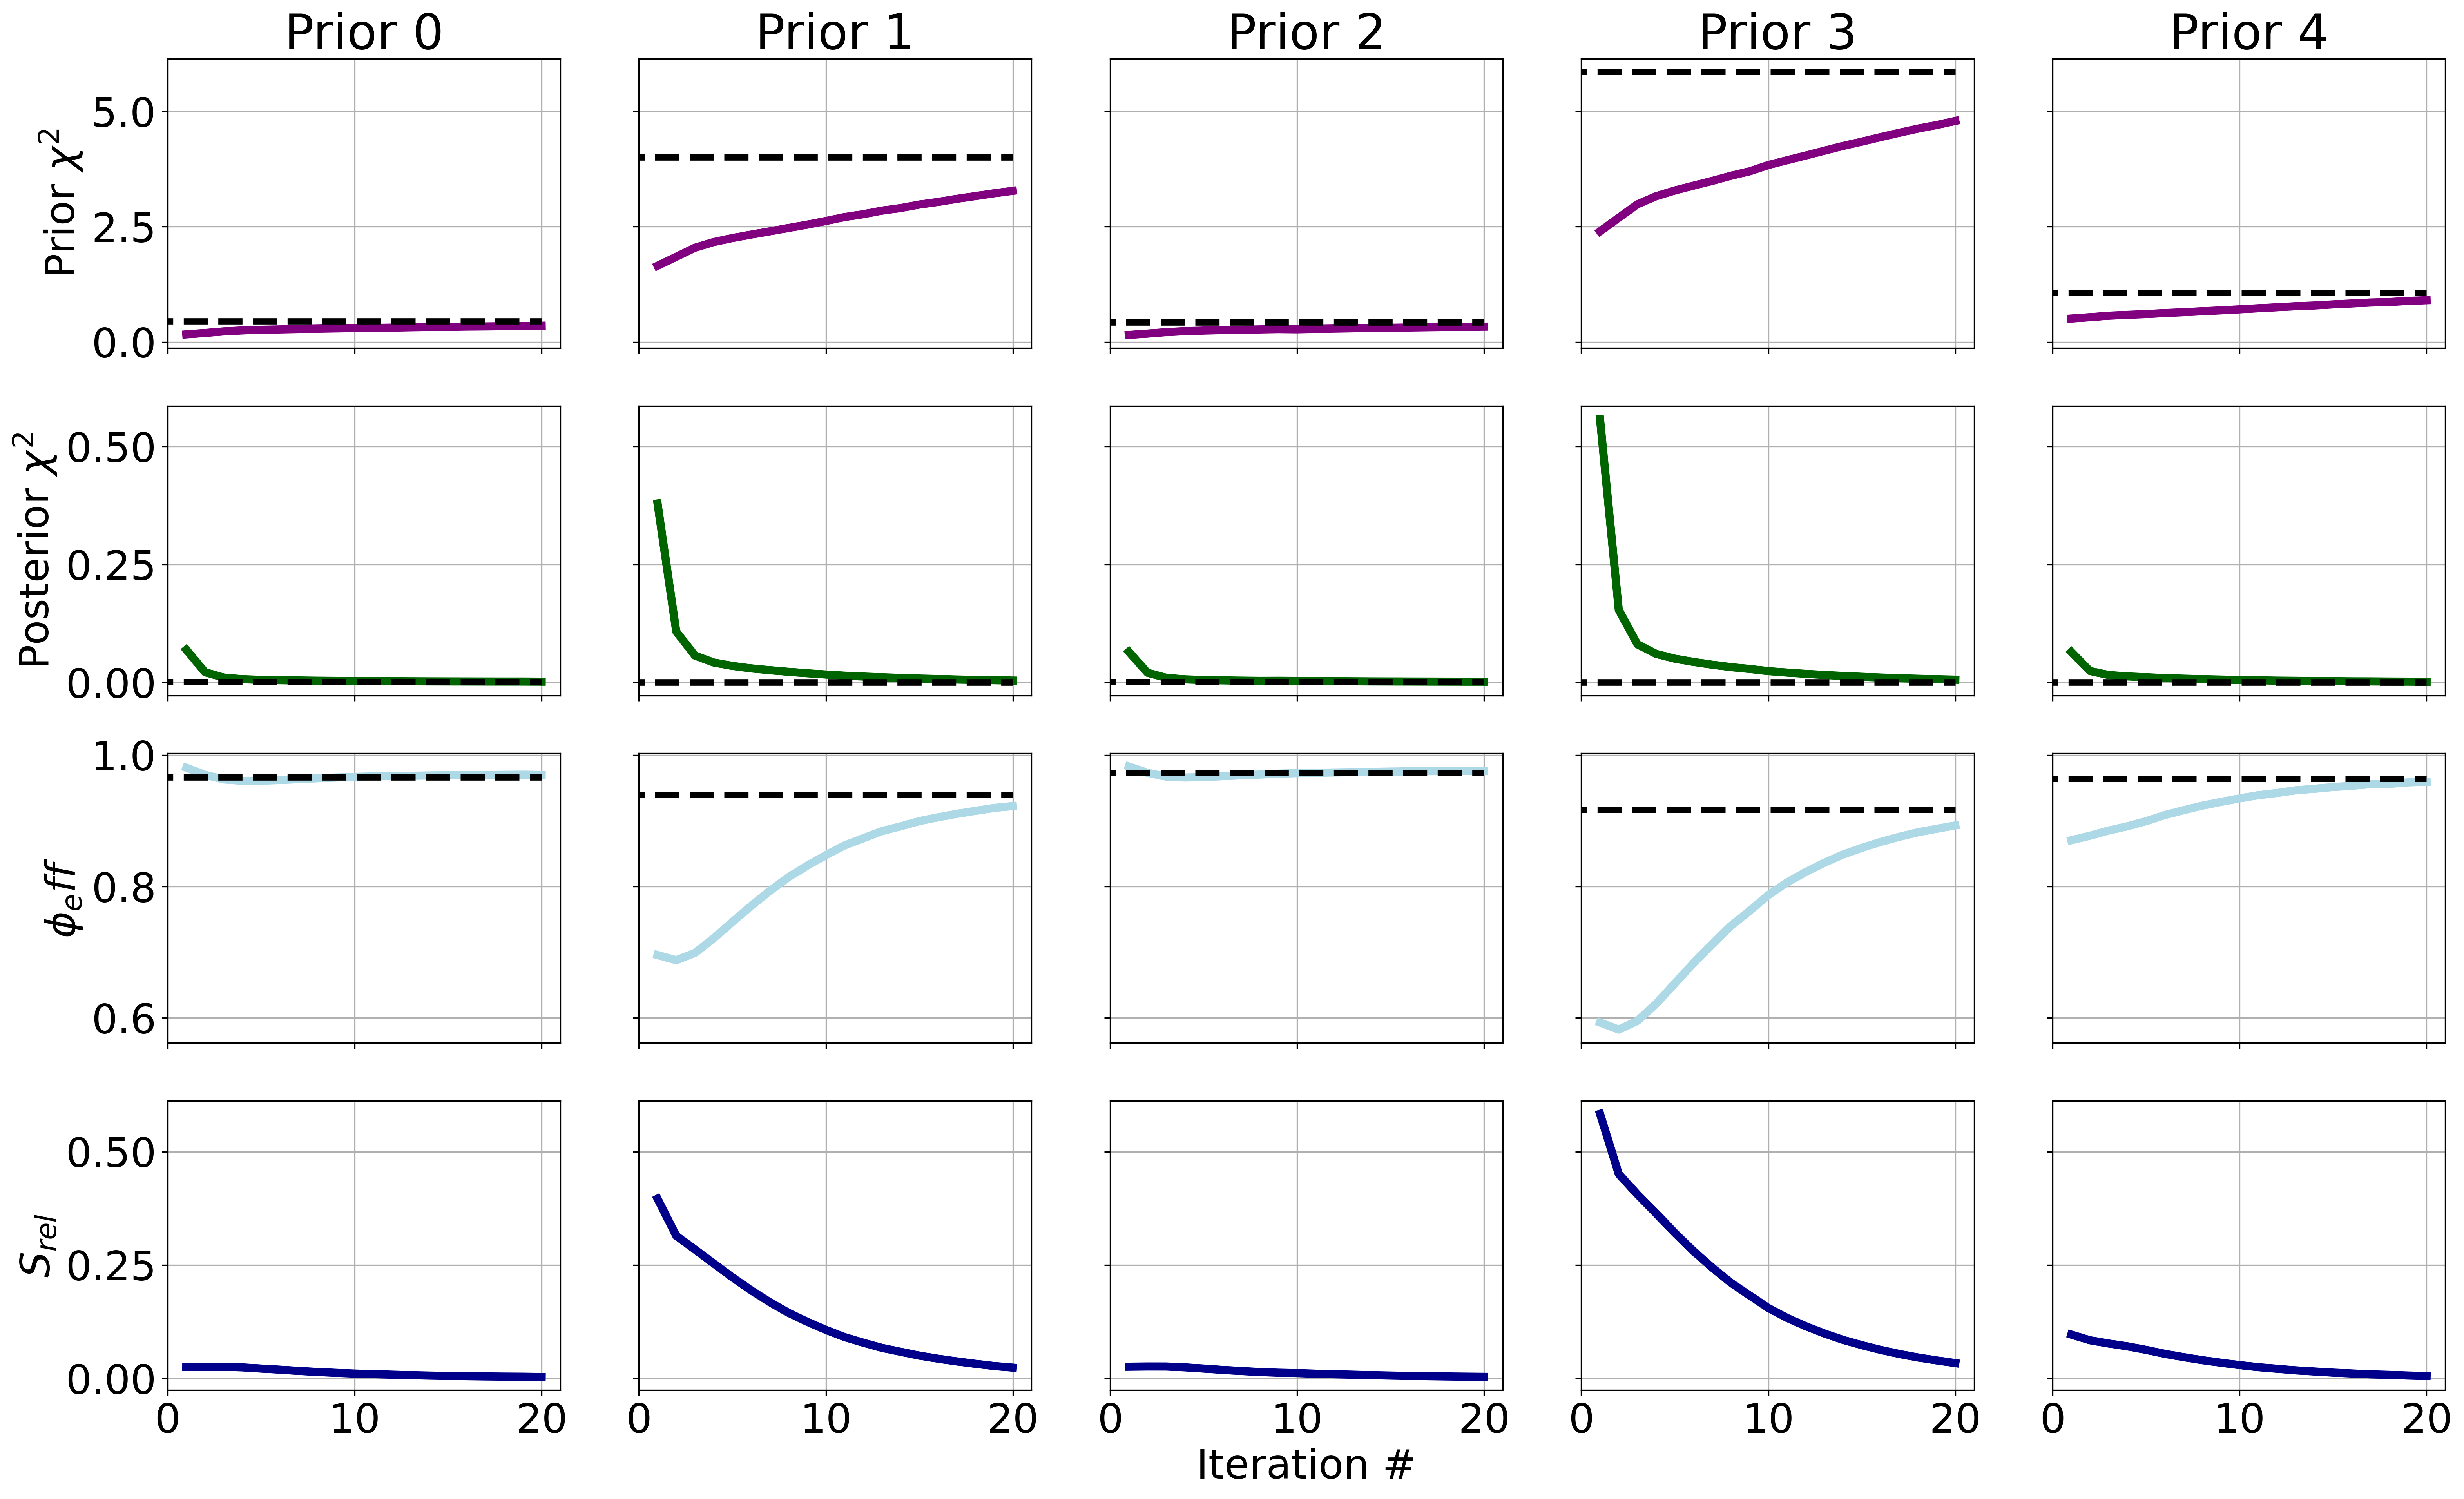

In [17]:
mpl.rcParams['font.size'] = 25

fig, axs = plt.subplots(4,5, sharex='col', sharey='row', figsize=(25, 15), dpi=300)

for n in range(5):
    data = np.array(ibme_stats[n])
    axs[0,n].plot(range(1,21),data[...,0],'purple',linewidth=5)
    axs[0,n].hlines(REdata_stand[n][1],-1,20,linewidth=4,linestyle='dashed',zorder=100,color='k')
    axs[0,n].grid()
    axs[0,n].set_xlim([0, 21])
    
    axs[1,n].plot(range(1,21),data[...,1],'darkgreen',linewidth=5)
    axs[1,n].hlines(REdata_stand[n][2],-1,20,linewidth=4,linestyle='dashed',zorder=100,color='k')
    axs[1,n].grid()
    axs[1,n].set_xlim([0, 21])
    
    axs[2,n].plot(range(1,21),data[...,2],'lightblue',linewidth=5)
    axs[2,n].hlines(REdata_stand[n][3],-1,20,linewidth=4,linestyle='dashed',zorder=100,color='k')
    axs[2,n].grid()
    axs[2,n].set_xlim([0, 21])
    
    axs[3,n].plot(range(1,21),ibme_srel[n],'darkblue',linewidth=5)
    axs[3,n].grid()
    axs[3,n].set_xlim([0, 21])

#fig.text(0.5, 0.04, 'Iteration #', va='center', ha='center')
axs[3,2].set(xlabel = 'Iteration #')

axs[0,0].set(ylabel=r'Prior $\chi^2$')
axs[1,0].set(ylabel=r'Posterior $\chi^2$')
axs[2,0].set(ylabel=r'$\phi_eff$')
axs[3,0].set(ylabel=r'$S_{rel}$')

axs[0,0].title.set_text('Prior 0')
axs[0,1].title.set_text('Prior 1')
axs[0,2].title.set_text('Prior 2')
axs[0,3].title.set_text('Prior 3')
axs[0,4].title.set_text('Prior 4')

plt.savefig('compar.pdf', dpi=300, facecolor='w', edgecolor='w', orientation='portrait')

plt.show()

## Grid scan with iBME optimization of the synthetic exp SAXS

In [18]:
grid = np.loadtxt('GRID_syn_uprior') #Load grid calculated using the uniform prior (same as the one used to generate synthetic experimental SAXS data)
#calculate \gamma
g = np.log(grid[...,4]/grid[...,5])
g = g.reshape(len(g),1)
grid = np.append(grid, g, axis=1)

/storage1/francesco/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


/storage1/francesco/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
/storage1/francesco/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


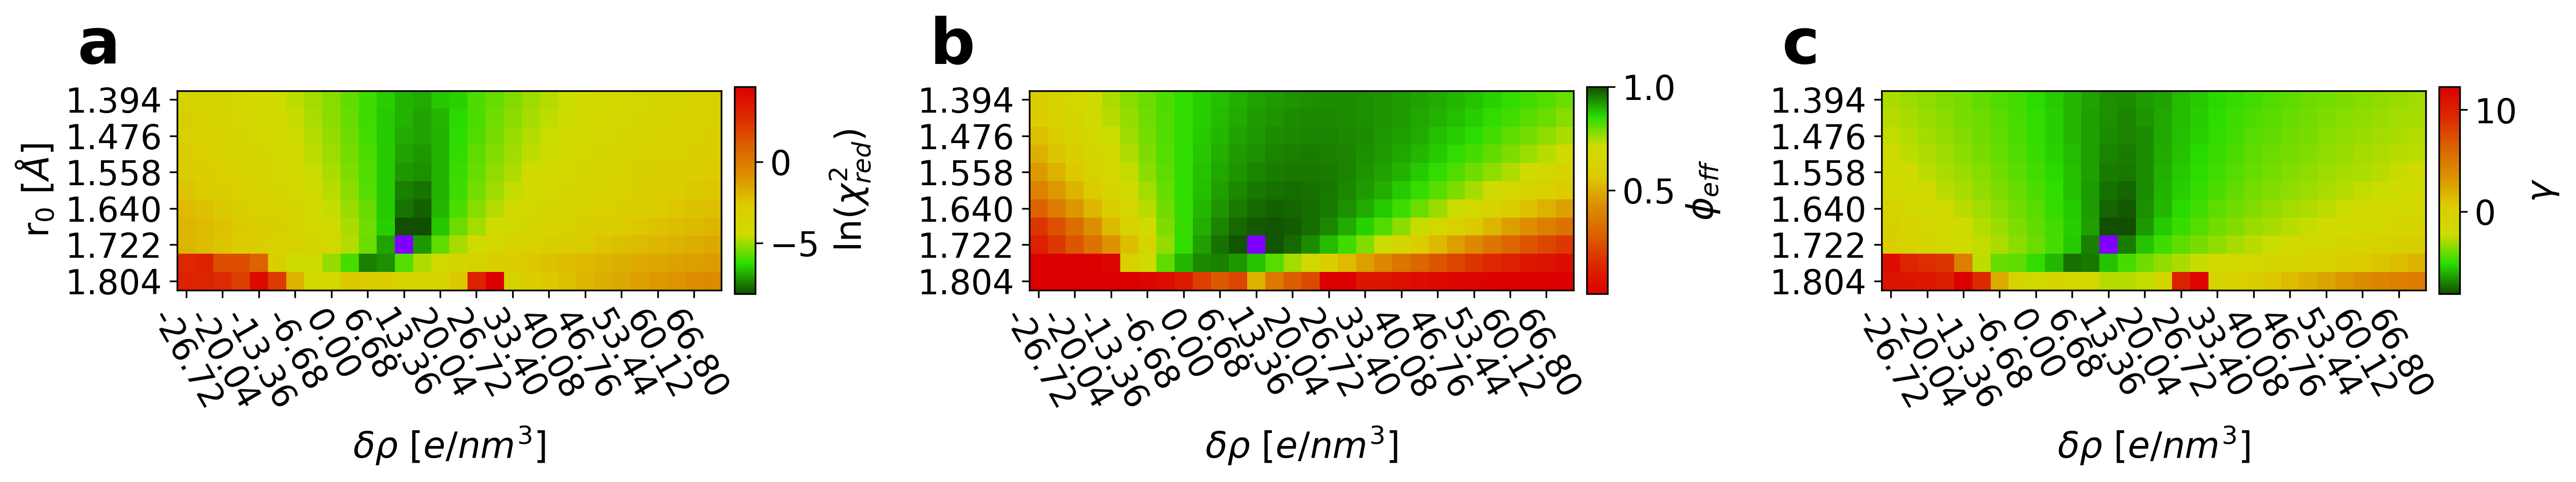

In [20]:
mpl.rcParams['font.size'] = 16
fig, axs = plt.subplots(nrows=1,ncols=3, figsize=(20,10), facecolor='w', dpi=300, gridspec_kw={'wspace':0.3})

yt = []
for i,x in enumerate(r0):
    if not (i+1)%2 == 0:
        yt.append('%.3f'%(x))
xt = []
for i,x in enumerate(dro):
    if not (i+1)%2 == 0:
        xt.append('%.2f'%(x))

im = axs[0].imshow(np.log(grid[...,4]).reshape(len(dro),len(r0)).T, cmap=rtg)
plt.colorbar(im, ax=axs[0],shrink=0.18,pad=0.02, aspect=10).set_label(r'$\ln(\chi^2_{red})$', fontsize=17)
axs[0].set_ylabel(r'r$_0$ $[\AA]$', fontsize=17)
mask = np.full(np.shape(grid[...,6]),np.inf)
mask[minfind(grid)[0]] = 100
axs[0].imshow(mask.reshape(len(dro),len(r0)).T, cmap=plt.cm.rainbow)

im = axs[1].imshow(grid[...,5].reshape(len(dro),len(r0)).T, cmap=rtg_r)
plt.colorbar(im, ax=axs[1],shrink=0.18,pad=0.02, aspect=10).set_label(r'$\phi_{eff}$', fontsize=17)
mask = np.full(np.shape(grid[...,6]),np.inf)
mask[minfind(grid)[0]] = 100
axs[1].imshow(mask.reshape(len(dro),len(r0)).T, cmap=plt.cm.rainbow)

im = axs[2].imshow(grid[...,6].reshape(len(dro),len(r0)).T, cmap=rtg)
plt.colorbar(im, ax=axs[2],shrink=0.18,pad=0.02, aspect=10).set_label(r'$\gamma$', fontsize=17)
mask = np.full(np.shape(grid[...,6]),np.inf)
mask[minfind(grid)[0]] = 100
axs[2].imshow(mask.reshape(len(dro),len(r0)).T, cmap=plt.cm.rainbow)

for i,ax in enumerate(axs):
    ax.text(-6,-2, string.ascii_lowercase[i], fontsize=30, weight='bold')

for i in range(3):
    axs[i].set_yticks(np.arange(0,len(r0),2))
    axs[i].set_yticklabels(yt)
    axs[i].set_xticks(np.arange(0,len(dro),2))
    axs[i].set_xticklabels(xt, Rotation=300)
    axs[i].set_xlabel(r'$\delta\rho$ $[e/nm^3]$', fontsize=17)
    
plt.savefig('sygrid_nopr.pdf', dpi=300, facecolor='w', edgecolor='w', orientation='portrait')
plt.show()

In [21]:
grid = np.loadtxt('GRID_syn') #Load grid calculated using the prior1 from the prvious iBME test
#calculate \gamma
g = np.log(grid[...,4]/grid[...,5])
g = g.reshape(len(g),1)
grid = np.append(grid, g, axis=1)

/storage1/francesco/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


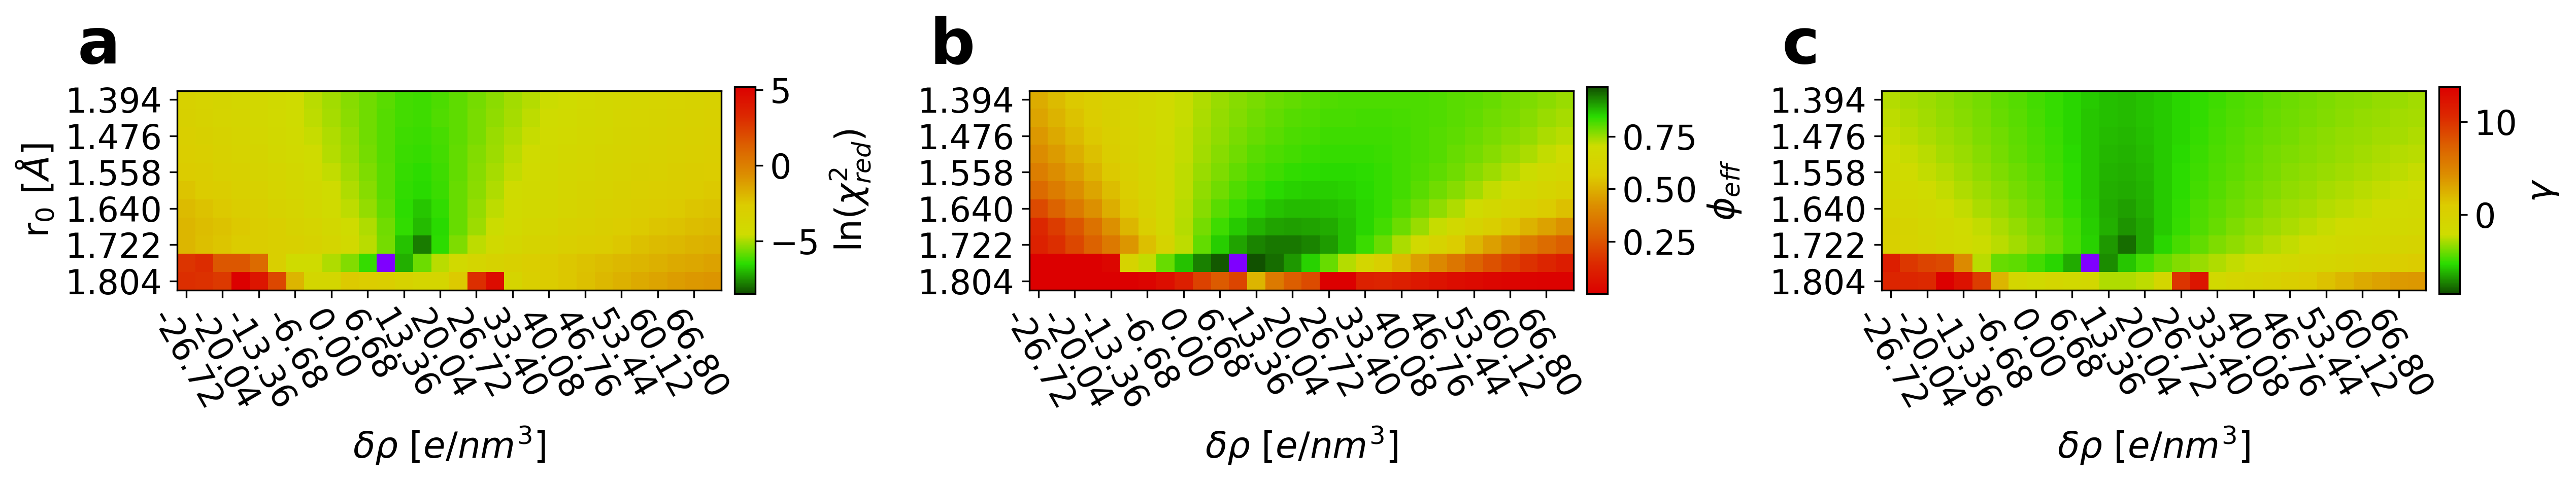

In [22]:
mpl.rcParams['font.size'] = 16
fig, axs = plt.subplots(nrows=1,ncols=3, figsize=(20,10), facecolor='w', dpi=300, gridspec_kw={'wspace':0.3})

yt = []
for i,x in enumerate(r0):
    if not (i+1)%2 == 0:
        yt.append('%.3f'%(x))
xt = []
for i,x in enumerate(dro):
    if not (i+1)%2 == 0:
        xt.append('%.2f'%(x))

im = axs[0].imshow(np.log(grid[...,4]).reshape(len(dro),len(r0)).T, cmap=rtg)
plt.colorbar(im, ax=axs[0],shrink=0.18,pad=0.02, aspect=10).set_label(r'$\ln(\chi^2_{red})$', fontsize=17)
axs[0].set_ylabel(r'r$_0$ $[\AA]$', fontsize=17)
mask = np.full(np.shape(grid[...,6]),np.inf)
mask[minfind(grid)[0]] = 100
axs[0].imshow(mask.reshape(len(dro),len(r0)).T, cmap=plt.cm.rainbow)

im = axs[1].imshow(grid[...,5].reshape(len(dro),len(r0)).T, cmap=rtg_r)
plt.colorbar(im, ax=axs[1],shrink=0.18,pad=0.02, aspect=10).set_label(r'$\phi_{eff}$', fontsize=17)
mask = np.full(np.shape(grid[...,6]),np.inf)
mask[minfind(grid)[0]] = 100
axs[1].imshow(mask.reshape(len(dro),len(r0)).T, cmap=plt.cm.rainbow)

im = axs[2].imshow(grid[...,6].reshape(len(dro),len(r0)).T, cmap=rtg)
plt.colorbar(im, ax=axs[2],shrink=0.18,pad=0.02, aspect=10).set_label(r'$\gamma$', fontsize=17)
mask = np.full(np.shape(grid[...,6]),np.inf)
mask[minfind(grid)[0]] = 100
axs[2].imshow(mask.reshape(len(dro),len(r0)).T, cmap=plt.cm.rainbow)

for i,ax in enumerate(axs):
    ax.text(-6,-2, string.ascii_lowercase[i], fontsize=30, weight='bold')

for i in range(3):
    axs[i].set_yticks(np.arange(0,len(r0),2))
    axs[i].set_yticklabels(yt)
    axs[i].set_xticks(np.arange(0,len(dro),2))
    axs[i].set_xticklabels(xt, Rotation=300)
    axs[i].set_xlabel(r'$\delta\rho$ $[e/nm^3]$', fontsize=17)
    
plt.savefig('sygrid_prior1.pdf', dpi=300, facecolor='w', edgecolor='w', orientation='portrait')
plt.show()